In [1]:
import configparser
import tweepy
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone
import time
import re
import hashlib
import networkx as nx

In [31]:
# get tokens
config = configparser.ConfigParser()
config.read('configfile.ini')
api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']
# authenticate
auth = tweepy.OAuth2AppHandler(api_key, api_key_secret)

In [32]:
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
def get_tweets_dataframe(working_df, tweets, hashtag):
    #working_df=working_df.drop_duplicates()
    print(f'working on {hashtag}')
    index=len(working_df)
    for tweet in tweets: 
        working_df.loc[index,'tweet_id']=tweet.id
        working_df.loc[index,'created_at']=tweet.created_at
        working_df.loc[index,'user']=tweet.user.screen_name
        working_df.loc[index,'full_text']=tweet.full_text
        working_df.loc[index,'favorite_count']=tweet.favorite_count
        working_df.loc[index,'retweet_count']=tweet.retweet_count
        working_df.loc[index,'hashtags']=hashtag
        #print(working_df.loc[index,'created_at'])
        #working_df=working_df.drop_duplicates()
        index+=1
        working_df.to_csv(f'tweeterhashtags/{hashtag}.csv', index=False)
        #time.sleep(1)
    working_df=working_df.drop_duplicates()
    working_df.to_csv(f'tweeterhashtags/{hashtag}.csv', index=False)
    working_df['created_at'] = pd.to_datetime(working_df['created_at'], utc=True)
    # Group the DataFrame by day
    grouped_df = working_df.groupby(pd.Grouper(key='created_at', freq='D'))

    # Calculate the count of rows for each day
    count_per_day = grouped_df['hashtags'].count()

    # Display the count per day
    print(count_per_day)
          
    return working_df

In [170]:
def get_tweets_from_general_tags(working_df, hashtag):
    #load and merge the general_tags
    print(f'working on {hashtag}')
    general_tags = ['#SaveLockwoodandCo', 'Lockwood and Co']
    general_tags_df=pd.DataFrame()
    for tag in general_tags:
        try:
            general_tags_df=pd.concat([general_tags_df, pd.read_csv(f'tweeterhashtags/{tag}.csv')], ignore_index=True)
        except:
            pass
    general_tags_df =general_tags_df.drop_duplicates()
    print(f'total generaltags: {len(general_tags_df)}')
    #general_tags_df['full_text'] = general_tags_df['full_text'].apply(lambda x: x.replace('\n',' ').replace(':', ' '))
    #Get the rows in the working_df that have the hashtag inside the full_text column
    hashtag_df = general_tags_df[general_tags_df['full_text'].apply(lambda x: hashtag.lower() in x.lower())]
    #hashtag_df = hashtag_df.reset_index(drop=True)
    hashtag_df['hashtags'] = hashtag
    working_df=pd.concat([working_df, hashtag_df], ignore_index=True)
    working_df=working_df.drop_duplicates()
    working_df['full_text'] = working_df['full_text'].apply(lambda x: x.replace('\n',' ').replace(':', ' '))
    working_df.to_csv(f'tweeterhashtags/{hashtag}.csv', index=False)
    working_df['created_at'] = pd.to_datetime(working_df['created_at'], utc=True)
    # Group the DataFrame by day
    grouped_df = working_df.groupby(pd.Grouper(key='created_at', freq='D'))

    # Calculate the count of rows for each day
    count_per_day = grouped_df['hashtags'].count()

    # Display the count per day
    print(count_per_day)
  
    return working_df

In [71]:
# Create a hash function to generate anonymized values
def anonymize(value):
    # Convert the value to a string and hash it using SHA256 algorithm
    hashed_value = hashlib.sha256(str(value).encode()).hexdigest()
    # Take the first 8 characters of the hash as the anonymized value
    anonymized_value = hashed_value[:8]
    return anonymized_value

In [43]:
hashtagsweek1 = ['#FridayNightatPortlandRow', '#HauntedWatchParty', '#WatchPartyatPortlandRow', '#HauntedbyaType3','#TogetherForLockwoodandCo','#PrimeForLockwoodandCo','#BringBackLockwoodandCo']
hashtagsweek2 = ['#GhostHuntersWatchParty', '#DisneyForLockwoodandCo', '#BBCforLockwoodandCo', '#AppleTVforLockwoodandCo', '#PrimeForLockwoodandCo', '#JustRecklessEnough']
hashtagsweek3 = ['#LockwoodGhostAuditions', '#ParamountForLockwoodandCo', '#ScullandCo','#RapiersReady', '#CaringforCarlyle', '#DEPRACisOnTheWay', '#BunsForBunchurch']
hashtagsweek4 = ['#CompleteFictionAppreciation', '#DisneySaveLockwood', '#ArtistryofLockwoodandCo', '#ParamountSaveLockwood', '#GhostStrike', '#LockwoodParallelFandoms', '#JustRecklessEnough']
hashtagsweek5 = ['#StroudsAppreciation', '#VoteLockwoodforNFA', '#PrimeSaveLockwood', '#ScreamingStaircase', '#DEPRACrollcall', '#LivingforLockwood', '#RapiersReady']
hashtagsall = hashtagsweek1+hashtagsweek2+hashtagsweek3+hashtagsweek4 + hashtagsweek5
hashtagsall = list(set(hashtagsall))

In [35]:
'''
phrase = 'Lockwood and Co'
try:
    working_df = pd.read_csv(f'tweeterhashtags/{phrase}.csv')
    print(len(working_df))
except:
    working_df = pd.DataFrame(columns=['tweet_id', 'created_at', 'user', 'full_text', 'favorite_count', 'retweet_count', 'hashtags'])
    
tweets = tweepy.Cursor(api.search_tweets, q=phrase, tweet_mode='extended').items()
working_df = get_tweets_dataframe(working_df, tweets, phrase)
    
working_df.drop_duplicates(inplace=True)
print(len(working_df))
    
time.sleep(60)

hashtag = '#SaveLockwoodandCo'
try:
    working_df = pd.read_csv(f'tweeterhashtags/{phrase}.csv')
    print(len(working_df))
except:
    working_df = pd.DataFrame(columns=['tweet_id', 'created_at', 'user', 'full_text', 'favorite_count', 'retweet_count', 'hashtags'])
    
tweets = tweepy.Cursor(api.search_tweets, q=hashtag, tweet_mode='extended').items()
working_df = get_tweets_dataframe(working_df, tweets, phrase)
    
working_df.drop_duplicates(inplace=True)
print(len(working_df))
    
time.sleep(60)
'''

19597


Rate limit reached. Sleeping for: 401
Rate limit reached. Sleeping for: 373
Rate limit reached. Sleeping for: 311


19990
created_at
2023-06-02 00:00:00+00:00     128
2023-06-03 00:00:00+00:00     626
2023-06-04 00:00:00+00:00     545
2023-06-05 00:00:00+00:00     885
2023-06-06 00:00:00+00:00    1447
2023-06-07 00:00:00+00:00    1832
2023-06-08 00:00:00+00:00    2316
2023-06-09 00:00:00+00:00    3419
2023-06-10 00:00:00+00:00    3711
2023-06-11 00:00:00+00:00    4475
2023-06-12 00:00:00+00:00     606
Freq: D, Name: hashtags, dtype: int64


In [40]:
for hashtag in hashtagsweek5:
    try:
        working_df=pd.read_csv(f'tweeterhashtags/{hashtag}.csv')
        #working_df = pd.read_csv('tweeterhashtags/#SkullandCo.csv')
        print(len(working_df))
    except:
        working_df=pd.DataFrame(columns=['tweet_id','created_at', 'user', 'full_text','favorite_count','retweet_count','hashtags'])
    tweets = tweepy.Cursor(api.search_tweets, q=hashtag, tweet_mode='extended').items()
    working_df = get_tweets_dataframe(working_df, tweets, hashtag)
    working_df=working_df.drop_duplicates()
    print(len(working_df))
    time.sleep(60)

#StroudsAppreciation#VoteLockwoodforNFA
0
Series([], Freq: D, Name: hashtags, dtype: int64)
#PrimeSaveLockwood
0
Series([], Freq: D, Name: hashtags, dtype: int64)
#ScreamingStaircase
0
Series([], Freq: D, Name: hashtags, dtype: int64)
#DEPRACrollcall
0
Series([], Freq: D, Name: hashtags, dtype: int64)
#LivingforLockwood
0
Series([], Freq: D, Name: hashtags, dtype: int64)
#RapiersReady
5248
5251
created_at
2023-05-28 00:00:00+00:00       1
2023-05-29 00:00:00+00:00       0
2023-05-30 00:00:00+00:00       0
2023-05-31 00:00:00+00:00      33
2023-06-01 00:00:00+00:00    4110
2023-06-02 00:00:00+00:00    1018
2023-06-03 00:00:00+00:00      58
2023-06-04 00:00:00+00:00       4
2023-06-05 00:00:00+00:00       2
2023-06-06 00:00:00+00:00       0
2023-06-07 00:00:00+00:00       4
2023-06-08 00:00:00+00:00      10
2023-06-09 00:00:00+00:00       0
2023-06-10 00:00:00+00:00       0
2023-06-11 00:00:00+00:00       3
2023-06-12 00:00:00+00:00       8
Freq: D, Name: hashtags, dtype: int64


In [172]:
hashtags = ['#SkullandCo']
for hashtag in hashtagsall:
    try:
        
        working_df=pd.read_csv(f'tweeterhashtags/{hashtag}.csv')
        print('try')
        working_df = get_tweets_from_general_tags(working_df, hashtag)
    except:
        working_df=pd.DataFrame(columns=['tweet_id','created_at', 'user', 'full_text','favorite_count','retweet_count','hashtags'])
        print('except')
        working_df = get_tweets_from_general_tags(working_df, hashtag)
        

try
working on #BBCforLockwoodandCo
total generaltags: 60207


/tmp/ipykernel_356/3358370044.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hashtag_df['hashtags'] = hashtag


created_at
2023-05-22 00:00:00+00:00      27
2023-05-23 00:00:00+00:00       1
2023-05-24 00:00:00+00:00    3881
2023-05-25 00:00:00+00:00    1297
2023-05-26 00:00:00+00:00     108
2023-05-27 00:00:00+00:00      13
2023-05-28 00:00:00+00:00      13
2023-05-29 00:00:00+00:00      11
2023-05-30 00:00:00+00:00       5
2023-05-31 00:00:00+00:00       8
2023-06-01 00:00:00+00:00       0
2023-06-02 00:00:00+00:00       0
2023-06-03 00:00:00+00:00       3
2023-06-04 00:00:00+00:00       2
2023-06-05 00:00:00+00:00       3
2023-06-06 00:00:00+00:00       0
2023-06-07 00:00:00+00:00       0
2023-06-08 00:00:00+00:00       3
2023-06-09 00:00:00+00:00       2
Freq: D, Name: hashtags, dtype: int64
try
working on #BunsForBunchurch
total generaltags: 60207
created_at
2023-05-29 00:00:00+00:00       7
2023-05-30 00:00:00+00:00       2
2023-05-31 00:00:00+00:00       2
2023-06-01 00:00:00+00:00       1
2023-06-02 00:00:00+00:00       0
2023-06-03 00:00:00+00:00      10
2023-06-04 00:00:00+00:00    743

In [189]:
working_df=pd.DataFrame()
for hashtag in hashtagsall:
    try:
        working_df=pd.concat([working_df, pd.read_csv(f'tweeterhashtags/{hashtag}.csv')], ignore_index=True)
    except:
        pass
len(working_df)

170364

In [190]:
working_df['full_text'] = working_df['full_text'].str.replace(r'"', '').replace(r'\n', ' ').replace(':', ' ')
working_df['full_text']

0         RT @aDEPRACofficial  Good morning Locknation! ...
1         RT @Thebiscuitrule  Just politely kicking in t...
2         RT @lockwoodandco13  we're almost at 17K! DON'...
3         RT @Tatty_paints  #SaveLockwoodandCo #BBCforLo...
4         RT @lavenderghostco  OH MY GOD THOSE NUMBERS 🔥...
                                ...                        
170359    RT @Thebiscuitrule  Just Cameron corpsing his ...
170360    RT @phinlands  top searches‼️‼️‼️  #SaveLockwo...
170361    RT @immzy_  OMG LOCKWOOD AND CO SEASON 2 SPOIL...
170362    RT @wordywallflower  @bunnyellabell I visited ...
170363    RT @phinlands  top searches‼️‼️‼️  #SaveLockwo...
Name: full_text, Length: 170364, dtype: object

In [191]:
# Create a new column 'retweet' with default value False
working_df['retweet'] = False

# Check if 'full_text' starts with 'RT ' and set 'retweet' column accordingly
working_df.loc[working_df['full_text'].str.startswith('RT '), 'retweet'] = True

working_df['retweet'].value_counts()

False    89431
True     80933
Name: retweet, dtype: int64

In [192]:
def get_week_label(week_number):
    if week_number == 20:
        return 'week1'
    elif week_number == 21:
        return 'week2'
    elif week_number == 22:
        return 'week3'
    elif week_number == 23:
        return 'week4'
    elif week_number == 24:
        return 'week5'
    else:
        return 'week1'


In [193]:
working_df['created_date'] = pd.to_datetime(working_df['created_at'], utc=True)
working_df['week'] = working_df['created_date'].dt.week
working_df['week'] = working_df['week'].apply(get_week_label)
working_df['week'].value_counts()

/tmp/ipykernel_356/1902887933.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  working_df['week'] = working_df['created_date'].dt.week


week1    45386
week4    44434
week3    42551
week2    36115
week5     1878
Name: week, dtype: int64

In [194]:
#Create an anonymized tweet_id
#working_df['unique_id'] = str(working_df['tweet_id']) + working_df['created_at'] + working_df['user'] + str(working_df['retweet'])
working_df['unique_id'] = working_df.apply(lambda row: str(row['tweet_id']) + row['created_at'] + row['user'] + str(row['retweet']), axis=1)
working_df['tweet_id'] = working_df['unique_id'].apply(anonymize)

In [195]:
hashtags_df = working_df[['tweet_id','hashtags']]
hashtags_df.to_csv('output/hashtags.csv', index=False)
working_df.value_counts('hashtags')

hashtags
#JustRecklessEnough             18080
#PrimeForLockwoodandCo          15216
#ParamountForLockwoodandCo       9880
#TogetherForLockwoodandCo        9413
#BunsForBunchurch                8704
#ParamountSaveLockwood           8589
#CompleteFictionAppreciation     8450
#BringBackLockwoodandCo          7823
#RapiersReady                    7246
#LockwoodParallelFandoms         6779
#LockwoodGhostAuditions          6424
#CaringforCarlyle                6187
#GhostStrike                     5880
#DisneyForLockwoodandCo          5848
#HauntedbyaType3                 5810
#BBCforLockwoodandCo             5377
#WatchPartyatPortlandRow         5255
#FridayNightatPortlandRow        5207
#DisneySaveLockwood              4927
#HauntedWatchParty               4838
#AppleTVforLockwoodandCo         4744
#GhostHuntersWatchParty          4249
#DEPRACisOnTheWay                3423
#ArtistryofLockwoodandCo         2013
#PrimeSaveLockwood                  2
dtype: int64

In [196]:
working_df=working_df.drop_duplicates('tweet_id')
working_df['tagged_users'] = working_df['full_text'].apply(lambda x: re.findall(r'@(\w+)', x))
working_df['tagged_users']

0                        [aDEPRACofficial]
1                    [Thebiscuitrule, bbc]
2                        [lockwoodandco13]
3                           [Tatty_paints]
4                        [lavenderghostco]
                        ...               
170358                    [Thebiscuitrule]
170359                    [Thebiscuitrule]
170360                         [phinlands]
170361                            [immzy_]
170362    [wordywallflower, bunnyellabell]
Name: tagged_users, Length: 120755, dtype: object

In [197]:
#Create a table for network analysis
na_df = working_df[['tweet_id','user', 'retweet', 'tagged_users']]
#na_df = na_df.drop_duplicates()
na_df

,tweet_id,user,retweet,tagged_users
0,cc636985,CayleeGuy,True,[aDEPRACofficial]
1,c405fe4f,CayleeGuy,True,"[Thebiscuitrule, bbc]"
2,e0a88e18,AndBenlovesrey,True,[lockwoodandco13]
3,16409b86,Icebirdzzz,True,[Tatty_paints]
4,2bae61eb,Icebirdzzz,True,[lavenderghostco]
...,...,...,...,...
170358,4656b9f6,amazonlite2727,True,[Thebiscuitrule]
170359,de3d38c8,DarkCyclePizza,True,[Thebiscuitrule]
170360,bd4573b3,NinaLinkor598,True,[phinlands]
170361,619abd4f,1sabellarry,True,[immzy_]


In [198]:
#Create a function that would create a dataframe that shows the interaction
def get_interaction(df):
    func_df = pd.DataFrame(columns = ['tweet_id', 'from', 'to'])
    for x in range(len(df)):
        if df['retweet'][0]=='True':
            new_row = {'tweet_id':df['tweet_id'].iloc[x], 'from':df['tagged_users'].iloc[x][0], 'to': df['user'].iloc[x]}
            func_df = func_df.append(new_row, ignore_index = True)
        else:
            for user in df['tagged_users'].iloc[x]:
                new_row = {'tweet_id':df['tweet_id'].iloc[x], 'to':user, 'from': df['user'].iloc[x]}
                func_df = func_df.append(new_row, ignore_index = True)
    return func_df.drop_duplicates()


In [199]:
na_interac_df = get_interaction(na_df)
na_interac_df

,tweet_id,from,to
0,cc636985,CayleeGuy,aDEPRACofficial
1,c405fe4f,CayleeGuy,Thebiscuitrule
2,c405fe4f,CayleeGuy,bbc
3,e0a88e18,AndBenlovesrey,lockwoodandco13
4,16409b86,Icebirdzzz,Tatty_paints
...,...,...,...
136967,de3d38c8,DarkCyclePizza,Thebiscuitrule
136968,bd4573b3,NinaLinkor598,phinlands
136969,619abd4f,1sabellarry,immzy_
136970,3fc51db7,TheLempMansion,wordywallflower


In [200]:
#get a unique user dataframe
list_of_user = na_interac_df['from'].append(na_interac_df['to'], ignore_index=True)
list_of_user = list(set(list_of_user))
user_df = pd.DataFrame(list_of_user, columns=['username'])
user_df['user'] = user_df['username'].apply(anonymize)
user_df=user_df.sort_values('username').reset_index()
user_df.to_csv('output/username.csv', index=False)

In [202]:
#anonymise the users from the different dataframes
na_interac_df['from'] = na_interac_df['from'].map(user_df.set_index('username')['user'])
na_interac_df['to'] = na_interac_df['to'].map(user_df.set_index('username')['user'])
working_df['user'] = working_df['user'].map(user_df.set_index('username')['user'])
na_interac_df.to_csv('output/userinteraction.csv', index=False)

In [4]:
na_interac_df = pd.read_csv('output/userinteraction.csv')

In [5]:
interac_grouped_df = na_interac_df.groupby(['from','to',])['tweet_id'].count().reset_index().sort_values(by='tweet_id',ascending=False).reset_index()
interac_grouped_df

,index,from,to,tweet_id
0,5825,27a03938,e1362151,559
1,289,019f08f0,e1362151,518
2,512,022e1f18,13ed0704,467
3,10115,4c4c7309,e1362151,458
4,33047,facd6e5a,e1362151,441
...,...,...,...,...
33560,14691,72de54f0,429542c4,1
33561,14689,72de54f0,3f65fdad,1
33562,14684,72de54f0,2a593ea6,1
33563,14683,72de54f0,291e6d79,1


In [8]:
num_tweets = interac_grouped_df.groupby('from')['tweet_id'].sum().sort_values(ascending=False).reset_index()

In [29]:
try_lang = interac_grouped_df[interac_grouped_df['tweet_id']>50]
try_lang

,index,from,to,tweet_id
0,5825,27a03938,e1362151,559
1,289,019f08f0,e1362151,518
2,512,022e1f18,13ed0704,467
3,10115,4c4c7309,e1362151,458
4,33047,facd6e5a,e1362151,441
...,...,...,...,...
316,19065,91081068,27a03938,51
317,5523,27a03938,049276fd,51
318,8257,3ae4c01a,e2417a24,51
319,24220,bf42abe7,1ef3160b,51


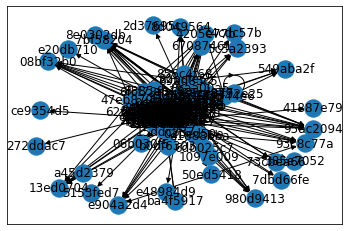

In [30]:
G = nx.from_pandas_edgelist(try_lang, source = 'from', target = 'to', edge_attr='tweet_id', create_using=nx.DiGraph())
nx.draw_networkx(G, with_labels=True)

In [203]:
working_df = working_df[['tweet_id', 'created_at', 'user', 'full_text', 'favorite_count', 'retweet_count', 'retweet', 'week']]
working_df.to_csv('output/tweets.csv', index=False)
working_df

,tweet_id,created_at,user,full_text,favorite_count,retweet_count,retweet,week
0,cc636985,2023-05-29 22:33:42+00:00,f31b1475,RT @aDEPRACofficial Good morning Locknation! ...,0.0,38.0,True,week3
1,c405fe4f,2023-05-29 22:33:30+00:00,f31b1475,RT @Thebiscuitrule Just politely kicking in t...,0.0,56.0,True,week3
2,e0a88e18,2023-05-29 09:58:58+00:00,35a18007,RT @lockwoodandco13 we're almost at 17K! DON'...,0.0,32.0,True,week3
3,16409b86,2023-05-29 05:57:39+00:00,3a5131c9,RT @Tatty_paints #SaveLockwoodandCo #BBCforLo...,0.0,32.0,True,week3
4,2bae61eb,2023-05-29 05:55:06+00:00,3a5131c9,RT @lavenderghostco OH MY GOD THOSE NUMBERS 🔥...,0.0,6.0,True,week3
...,...,...,...,...,...,...,...,...
170358,4656b9f6,2023-06-01 21:37:25+00:00,ea3b9f01,RT @Thebiscuitrule Just Cameron corpsing his ...,0.0,13.0,True,week3
170359,de3d38c8,2023-06-01 21:11:35+00:00,8885ab18,RT @Thebiscuitrule Just Cameron corpsing his ...,0.0,13.0,True,week3
170360,bd4573b3,2023-05-30 17:35:58+00:00,7f052500,RT @phinlands top searches‼️‼️‼️ #SaveLockwo...,0.0,47.0,True,week3
170361,619abd4f,2023-05-28 08:32:35+00:00,8cae97a8,RT @immzy_ OMG LOCKWOOD AND CO SEASON 2 SPOIL...,0.0,40.0,True,week2


In [204]:
set(hashtags_df['tweet_id'])==set(working_df['tweet_id'])

True